In [2]:
import pickle

import jax
import jax.numpy as jnp
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

import StreaMAX as smx

In [57]:
halo_dict = {
    'logM': 11.64,
    'Rs':16.,
    'a':1.0,
    'b':1.0,
    'c':1.0,
    'x_origin':0.0,
    'y_origin':0.0,
    'z_origin':0.0,
    'dirx':0.0,
    'diry':0.0,
    'dirz':1.0
}

disc_dict = {
    'logM': 10.84,
    'Rs': 3.0,
    'Hs': 0.28,
    'x_origin': 0.0,
    'y_origin': 0.0,
    'z_origin': 0.0,
    'dirx': 0.0,
    'diry': 0.0,
    'dirz': 1.0
}

bar_dict = {
    'A': jnp.fabs(smx.potentials.MiyamotoNagai_potential(0, 0, 0, disc_dict)),
    'Rs': 4.0,
    'Hs': 0.5,
    'Omega': 35.0,
    't0': 0.5,
    't1': 1.5,
    'x_origin': 0.0,
    'y_origin': 0.0,
    'z_origin': 0.0,
    'dirx': 0.0,
    'diry': 0.0,
    'dirz': 1.0
}

@jax.jit
def acc_fn(x, y, z, t, halo_dict, disc_dict, bar_dict):
    a_halo = smx.potentials.NFW_acceleration(x, y, z, halo_dict)
    a_disk = smx.potentials.MiyamotoNagai_acceleration(x, y, z, disc_dict)
    a_bar  = smx.potentials.Bar_acceleration(x, y, z, t, bar_dict)
    return a_halo + a_disk + a_bar

with open('./ic_thin_1015.pickle', 'rb') as f:
    ic = pickle.load(f)
w0 = jnp.array([ic['x'], ic['y'], ic['z'], ic['vx'], ic['vy'], ic['vz']]).T

n_particles = 100000
w0 = w0[:n_particles]
time = 4.
n_steps = 1000
dt = time / n_steps
unroll = False

In [ ]:
def _split(w):
    return w[:3], w[3:]

def _merge(r, v):
    return jnp.concatenate([r, v], axis=0)

@partial(jax.jit, static_argnames=('acc_fn', 'n_steps', 'unroll'))
def integrate_leapfrog_traj(w0, params_halo, params_disk, params_bar, acc_fn, n_steps, dt = 0.010, t0 = 0.0, unroll=True):
    """Leapfrog (KDK) — returns final time and final state only."""

    def step(carry, _):
        t, y = carry
        r, v = _split(y)
        a0 = acc_fn(*r, t, params_halo, params_disk, params_bar)
        v_half = v + 0.5 * dt * a0
        r_new = r + dt * v_half
        t_new = t + dt
        a1 = acc_fn(*r_new, t_new, params_halo, params_disk, params_bar)
        v_new = v_half + 0.5 * dt * a1
        y_new = _merge(r_new, v_new)
        return (t_new, y_new), (t_new, y_new)

    (_, _), (tN, wN) = jax.lax.scan(step, (t0, w0), xs=None, length=n_steps, unroll=unroll)
    return tN, wN

In [59]:
t_all, xv_all = jax.vmap(integrate_leapfrog_traj, in_axes=(0, None, None, None, None, None, None, None, None)) \
                                        (w0, halo_dict, disc_dict, bar_dict, acc_fn, n_steps, dt, 0., False)

In [2]:
# arg_take = jnp.where((t_all[0]- bar_dict['t1']) > 0.)[0]

# t_in = t_all[:, arg_take]
# xv_in = xv_all[:, arg_take]

# angles = -t_all[:, arg_take] * bar_dict['Omega']

@jax.jit
def bar_frame(xv, angle):
    # Rotate contourclockwise with positive angle
    sina, cosa = jnp.sin(angle), jnp.cos(angle)
    xv = xv.at[:,0].set(xv[:,0]*cosa-xv[:,1]*sina)
    xv = xv.at[:,1].set(xv[:,0]*sina+xv[:,1]*cosa)
    xv = xv.at[:,3].set(xv[:,3]*cosa-xv[:,4]*sina)
    xv = xv.at[:,4].set(xv[:,3]*sina+xv[:,4]*cosa)
    return xv

angles = -t_all * bar_dict['Omega']
xv_bar_ref = jax.vmap(jax.vmap(bar_frame, in_axes=(0,0)), in_axes=(0,0))(xv_all, angles)

NameError: name 'jax' is not defined

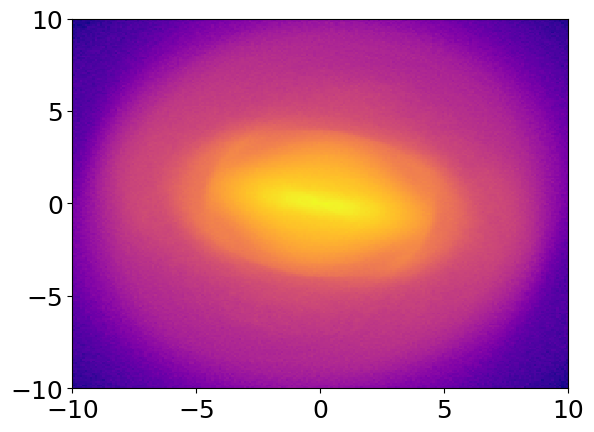

In [61]:
plt.hist2d(xv_bar_ref[:,:,0].flatten(), xv_bar_ref[:,:,1].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

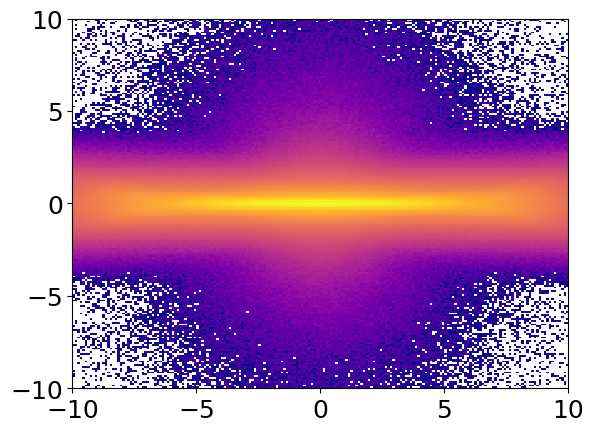

In [62]:
plt.hist2d(xv_bar_ref[:,:,0].flatten(), xv_bar_ref[:,:,2].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

In [63]:
with open('./ic_thick_1015.pickle', 'rb') as f:
    ic = pickle.load(f)
w0_thick = jnp.array([ic['x'], ic['y'], ic['z'], ic['vx'], ic['vy'], ic['vz']]).T

n_thick_particles = 10000
w0_thick = w0_thick[:n_thick_particles]

t_guess, xv_guess = jax.vmap(integrate_leapfrog_traj, in_axes=(0, None, None, None, None, None, None, None, None)) \
                                        (w0_thick, halo_dict, disc_dict, bar_dict, acc_fn, n_steps, dt, 0., False)

In [64]:
arg_take_guess = jnp.where((t_guess[0]- bar_dict['t1']) > 0.)[0]

t_guess_in = t_guess[:, arg_take_guess]
xv_guess_in = xv_guess[:, arg_take_guess]

angles_guess = -t_guess[:, arg_take_guess] * bar_dict['Omega']

@jax.jit
def bar_frame(x, y, z, vx, vy, vz, angle):
    # Rotate contourclockwise with positive angle
    sina, cosa = jnp.sin(angle), jnp.cos(angle)
    return jnp.array([x*cosa-y*sina, x*sina+y*cosa, z, vx*cosa-vy*sina, vx*sina+vy*cosa, vz]).T

xv_bar_ref_guess = jax.vmap(bar_frame, in_axes=(0,0,0,0,0,0,0))(xv_guess_in[:,:,0], xv_guess_in[:,:,1], xv_guess_in[:,:,2], xv_guess_in[:,:,3], xv_guess_in[:,:,4], xv_guess_in[:,:,5], angles_guess)

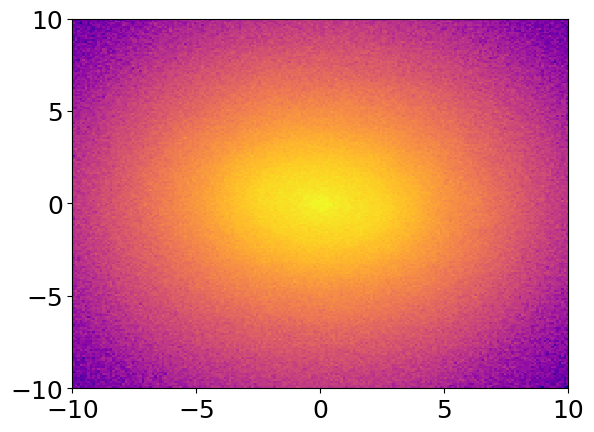

In [66]:
plt.hist2d(xv_bar_ref_guess[:,:,0].flatten(), xv_bar_ref_guess[:,:,1].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

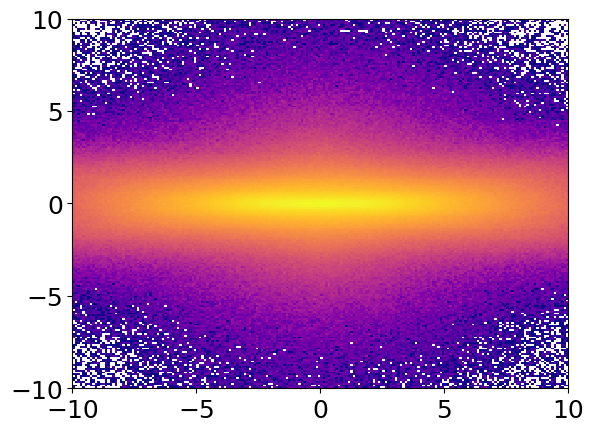

In [67]:
plt.hist2d(xv_bar_ref_guess[:,:,0].flatten(), xv_bar_ref_guess[:,:,2].flatten(), bins=200, range=[[-10,10],[-10,10]], density=True, cmap='plasma', norm='log');

## Ok, time to fight the weights in 3D

In [77]:
xlim = [-10, 10]
ylim = [-10, 10]
zlim = [-5, 5]

# Bin the positions in 3D using numpy.histogramdd
bins = [
    np.arange(xlim[0], xlim[1] + 0.5, 0.5),
    np.arange(ylim[0], ylim[1] + 0.5, 0.5),
    np.arange(zlim[0], zlim[1] + 0.5, 0.5)
]

positions = np.stack([
    xv_bar_ref[:,:,0].flatten(),
    xv_bar_ref[:,:,1].flatten(),
    xv_bar_ref[:,:,2].flatten()
], axis=1)

hist3d, edges = np.histogramdd(positions, bins=bins)

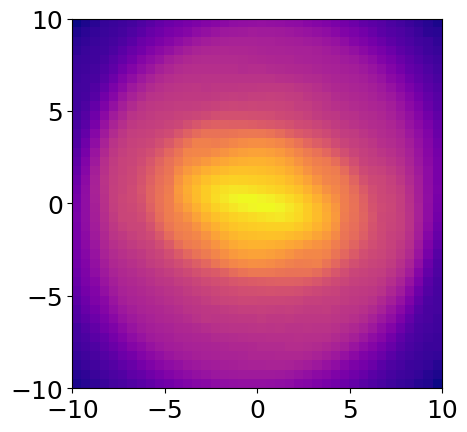

In [78]:
plt.imshow(np.log10(hist3d.sum(axis=2).T + 1), origin='lower', extent=[xlim[0], xlim[1], ylim[0], ylim[1]], cmap='plasma');

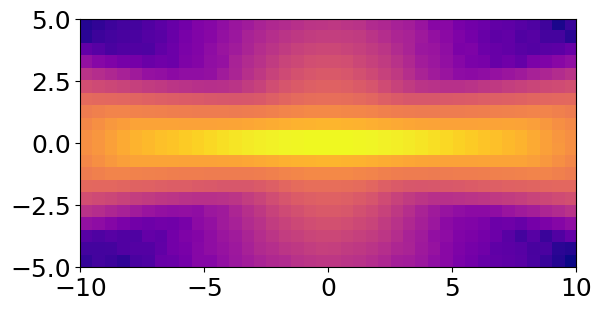

In [79]:
plt.imshow(np.log10(hist3d.sum(axis=1).T + 1), origin='lower', extent=[xlim[0], xlim[1], zlim[0], zlim[1]], cmap='plasma');

# Trying to get Phi_m

In [1]:
from CylindricalSpline import *
from densities import *
from potentials import *
import time as tt

import matplotlib.pyplot as plt

In [2]:
rho_fn = MiyamotoNagai_density
params = {
    'logM': 9.,
    'Rs': 3.,
    'Hs': 0.8,
    'x_origin': 0.,
    'y_origin': 0.,
    'z_origin': 0.,
    'dirx': 0.,
    'diry': 0.,
    'dirz': 1.,
}

NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax = 50, 30, 1e-2, 30.0, 1e-2, 20.0, 0.
Nphi = 200
N_int = 50_000

a = tt.time()
pot_data = jax.block_until_ready(get_phi_m(rho_fn, params, NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax, Nphi, N_int))
b = tt.time()
print(f'Time to get Phi_m: {(b-a)*1000:.2f} ms')


Time to get Phi_m: 2626.54 ms


In [5]:
rho_fn = DoubleExponentialDiskx2FerrersBar_density
params = {
    'Sigma0_thin': 1.,
    'Rd_thin': 3.,
    'hz_thin': 0.2,
    'x_origin_thin': 0.,
    'y_origin_thin': 0.,
    'z_origin_thin': 0.,
    'dirx_thin': 0.,
    'diry_thin': 0.,
    'dirz_thin': 1.,

    'Sigma0_thick': 1.,
    'Rd_thick': 1.8,
    'hz_thick': 0.8,
    'x_origin_thick': 0.,
    'y_origin_thick': 0.,
    'z_origin_thick': 0.,
    'dirx_thick': 0.,
    'diry_thick': 0.,
    'dirz_thick': 1.,

    'a_bar': 4.,
    'b_bar': 1.5,
    'c_bar': 0.8,
    'rho0_bar': 1.,
    'n_bar': 2.,
    'phi_bar_deg': jnp.deg2rad(25.0),
    'x_origin': 0.,
    'y_origin': 0.,
    'z_origin': 0.,
    'dirx': 0.,
    'diry': 0.,
    'dirz': 1.,
}

NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax = 50, 30, 1e-2, 30.0, 1e-3, 15.0, 8.
Nphi = 200
N_int = 10_000

a = tt.time()
pot_data = get_phi_m(rho_fn, params, NR, NZ, Rmin, Rmax, Zmin, Zmax, Mmax, Nphi, N_int)
b = tt.time()
print(f'Time to get Phi_m: {(b-a)*1000:.2f} ms')

Time to get Phi_m: 1.37 ms


In [8]:
nn = 100
x = np.linspace(-10, 10, nn)
y = np.linspace(-10, 10, nn)
z = np.linspace(-0.5, 0.5, nn)
X, Y, Z = np.meshgrid(x, y, z)
dZ = Z[1] - Z[0]

gt_densities    = jax.vmap(rho_fn, in_axes=(0, 0, 0, None))(X, Y, Z, params)
# gt_potential = jax.vmap(MiyamotoNagai_potential, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), params).reshape((nn, nn, nn))
# gt_acceleration    = jax.vmap(MiyamotoNagai_acceleration, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), params).reshape((3, nn, nn, nn))

potential = jax.vmap(evaluate_phi, in_axes=(0, 0, 0, None))(X, Y, Z, pot_data)
acceleration = jax.vmap(get_acc, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), pot_data).reshape((3, nn, nn, nn))
hessians = jax.vmap(get_hessian, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), pot_data).reshape((9, nn, nn, nn))
densities = jax.vmap(get_density, in_axes=(0, 0, 0, None))(X.ravel(),Y.ravel(),Z.ravel(), pot_data).reshape((nn, nn, nn))

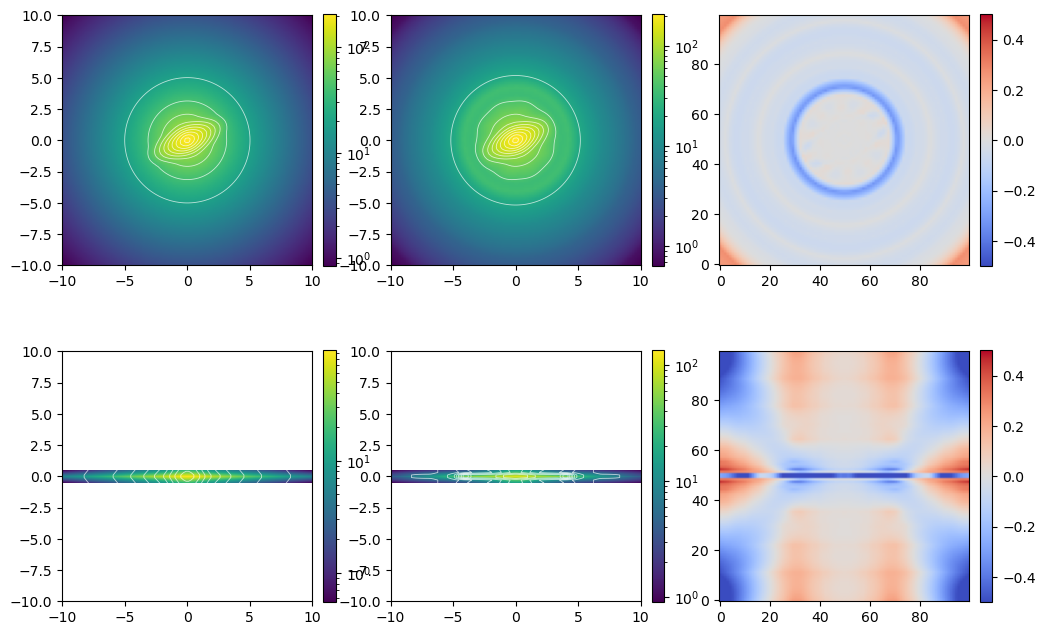

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(2,3,1)
plt.imshow(jnp.sum(gt_densities, axis=2), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], norm = 'log')
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
x,y, jnp.sum(gt_densities, axis=2),
levels=10,
colors="white",
linewidths=0.6,
alpha=0.7,
)
# plt.axis('off')
plt.subplot(2,3,2)
plt.imshow(jnp.sum(densities, axis=2), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], norm = 'log')
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
x,y, jnp.sum(densities, axis=2),
levels=10,
colors="white",
linewidths=0.6,
alpha=0.7,
)
# plt.axis('off')
plt.subplot(2,3,3)
# res = jnp.sum((densities-gt_densities)/gt_densities, axis=2)#
res = (jnp.sum(gt_densities, axis=2) - jnp.sum(densities, axis=2)) / jnp.sum(gt_densities, axis=2)
mm = 0.5
plt.imshow(res, origin='lower', cmap='coolwarm', vmin=-mm, vmax=mm)
plt.colorbar(fraction=0.046, pad=0.04)
# plt.axis('off')
plt.subplot(2,3,4)
plt.imshow(jnp.sum(gt_densities, axis=1).T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()], norm = 'log')
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
X[:, :, 0], Y[:, :, 0], jnp.sum(gt_densities, axis=1).T,
levels=10,
colors="white",
linewidths=0.6,
alpha=0.7,
)
# plt.axis('off')
plt.subplot(2,3,5)
plt.imshow(jnp.sum(densities, axis=1).T, origin='lower', extent=[x.min(), x.max(), z.min(), z.max()], norm = 'log')
plt.colorbar(fraction=0.046, pad=0.04)
plt.contour(
X[:, :, 0], Y[:, :, 0], jnp.sum(densities, axis=1).T,
levels=10,
colors="white",
linewidths=0.6,
alpha=0.7,
)
# plt.axis('off')
plt.subplot(2,3,6)
# res = jnp.sum(100*(densities-gt_densities)/gt_densities, axis=1)
res = (jnp.sum(gt_densities, axis=1) - jnp.sum(densities, axis=1)) / jnp.sum(gt_densities, axis=1)
mm = 0.5#jnp.max(abs(res))
plt.imshow(res.T, origin='lower', cmap='coolwarm', vmin=-mm, vmax=mm)#, extent=[x.min(), x.max(), z.min(), z.max()]
plt.colorbar(fraction=0.046, pad=0.04)
# plt.axis('off')

Text(0, 0.5, 'AME of density')

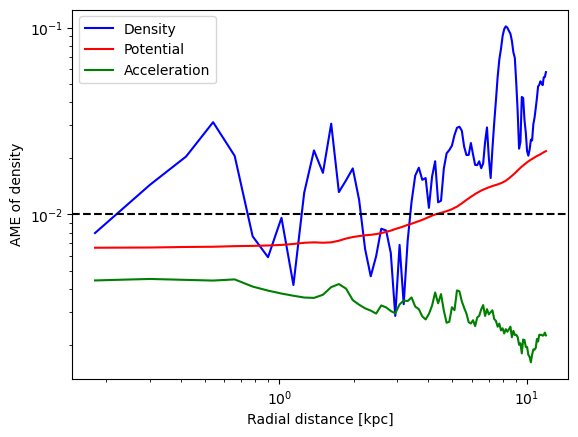

In [274]:
import jax
import jax.numpy as jnp

import numpy as np

def compute_radial_ame(rho1, rho2, x, y, z, r_edges):
    """
    Compute radial Absolute Mean Error (AME) between two density cubes.

    Parameters
    ----------
    rho1, rho2 : (Nx,Ny,Nz) arrays
        The two density cubes to compare.
    x, y, z : 1D arrays
        Coordinate axes of the cube (uniform or non-uniform).
    r_edges : 1D array
        Radial bin edges (e.g. np.linspace(0, Rmax, Nr+1)).

    Returns
    -------
    r_centers : 1D array
        Bin centers.
    ame : 1D array
        Absolute mean error per radial shell.
    """

    # build full coordinate grid
    X, Y, Z = np.meshgrid(x, y, z, indexing="ij")
    r = np.sqrt(X**2 + Y**2 + Z**2)

    abs_err = np.abs((rho1 - rho2)/rho1)

    nbins = len(r_edges) - 1
    r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])
    ame = np.zeros(nbins)

    for i in range(nbins):
        rmin = r_edges[i]
        rmax = r_edges[i+1]

        # mask of voxels inside this shell
        mask = (r >= rmin) & (r < rmax)

        if np.any(mask):
            ame[i] = abs_err[mask].mean()
        else:
            ame[i] = np.nan  # or 0.0

    return r_centers, ame


r_edges = jnp.linspace(0, 12, 101)

# Compute AME(r)
r_centers, ame_rho = compute_radial_ame(gt_densities, densities, x, y, z, r_edges)
r_centers, ame_phi = compute_radial_ame(gt_potential, potential, x, y, z, r_edges)
r_centers, ame_accx = compute_radial_ame(gt_acceleration[0], acceleration[0], x, y, z, r_edges)
r_centers, ame_accy = compute_radial_ame(gt_acceleration[1], acceleration[1], x, y, z, r_edges)
r_centers, ame_accz = compute_radial_ame(gt_acceleration[2], acceleration[2], x, y, z, r_edges)
r_centers, ame_acc = compute_radial_ame(np.linalg.norm(gt_acceleration, axis=0), np.linalg.norm(acceleration, axis=0), x, y, z, r_edges)


plt.plot(r_centers, ame_rho, c='b', label='Density')
plt.plot(r_centers, ame_phi, c='r', label='Potential')
# plt.plot(r_centers, ame_accx, c='r')
# plt.plot(r_centers, ame_accy, '--r')
# plt.plot(r_centers, ame_accz, ':r')
plt.plot(r_centers, ame_acc, 'g', label='Acceleration')
plt.legend(loc='best')

plt.axhline(0.01, c='k', linestyle='--')

plt.loglog()
plt.xlabel('Radial distance [kpc]')
plt.ylabel('AME of density')

In [275]:
from integrants import *

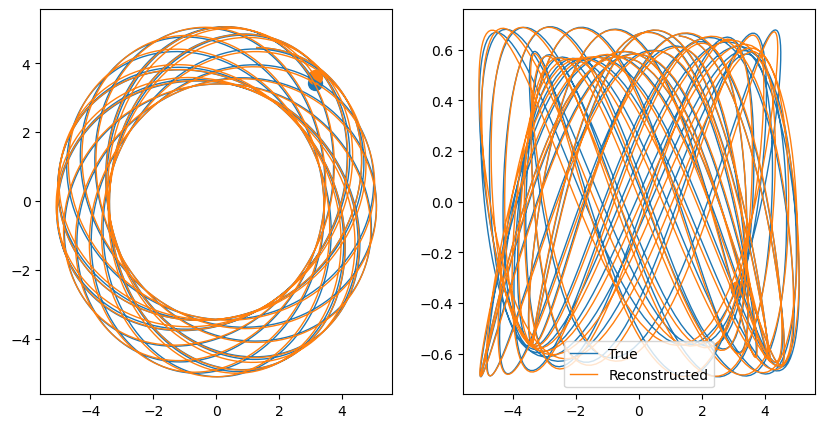

In [290]:
w0 = np.random.normal(0, 5, size=6)
n_steps = 2000

gtN, gwN = integrate_leapfrog_traj(w0, params, MiyamotoNagai_acceleration, n_steps, dt = 0.010, t0 = 0.0, unroll=False)

tN, wN = integrate_leapfrog_traj(w0, pot_data, get_acc, n_steps, dt = 0.010, t0 = 0.0, unroll=False)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(gwN[:,0], gwN[:,1], label='True', linewidth=1)
plt.scatter(gwN[-1,0], gwN[-1,1], s=100)
plt.plot(wN[:,0], wN[:,1], label='Reconstructed', linewidth=1)
plt.scatter(wN[-1,0], wN[-1,1], s=100)
plt.subplot(1,2,2)
plt.plot(gwN[:,0], gwN[:,2], label='True', linewidth=1)
plt.scatter(gwN[-1,0], gwN[-1,2], s=100)
plt.plot(wN[:,0], wN[:,2], label='Reconstructed', linewidth=1)
plt.scatter(wN[-1,0], wN[-1,2], s=100)
plt.legend(loc='best')

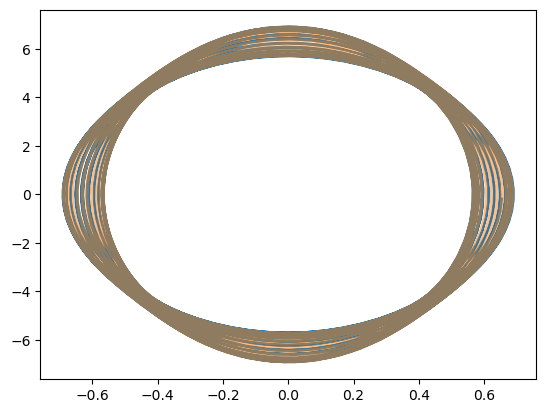

In [303]:
plt.plot(gwN[:, 2], gwN[:, 5])
plt.plot(wN[:, 2], wN[:, 5], alpha=0.5)

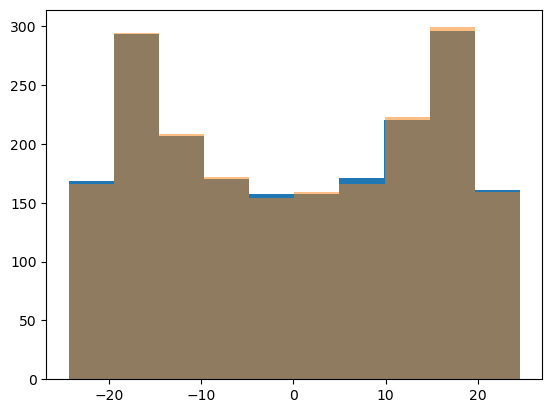

In [298]:
plt.hist(gwN[:, 3]);
plt.hist(wN[:, 3], alpha=0.5);